# Partie Equity


#### Pricing de produits vanilles:

- `VanillaPricerWithVolConstante.py`
- `VanillaPricerWithInterpolatedSmile.py`
- `VanillaPricerWithHeston.py`

#### Pricing de produit exotiques et vanilles:

- `MonteCarloPricerBS.py` 
- `MonteCarloPricerHeston.py`

Dans ce notebook, nous nous concentrons sur l'explication de l'approche de Monte Carlo et sur la calibration du modèle d'Heston.

In [16]:
from MonteCarloPricerBS import *
from MonteCarloSimulator import *
from MonteCarloPricerHeston import * 
from VanillaPricerWithHeston import *
from VanillaPricerWithHeston import * 
from VanillaPricerWithVolConstante import *
from BlackScholesModelClosedFormula import *
from VolatilitySurface import VolatilitySurface
from pandas.tseries.offsets import BDay
import pandas as pd


In [20]:
market_date, ticker= (datetime.datetime.today() - BDay(1)).date(), 'AAPL'
appl_vol_surface_from_calls = VolatilitySurface(market_date=market_date, ticker=ticker, mode='Calls', r=0.04, d =0.01)

c:\Users\moham\OneDrive\Bureau\asset_pricing_project\import_data\import_data.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return self.ticker.history(start = start_date, end = end_date)['Close'][0]


Sachant que pour les produits exotiques, nous n'avons pas de formule fermée pour le payoff, nous utilisons une approche de Monte Carlo (antithetique) afin de calculer leur espérance en utilisant la solution de l'Équation Différentielle Stochastique (EDS) de Black-Scholes qui est donnée par :

$$
S_t = S_0 \exp\left[ \left( r - d - \frac{\sigma^2}{2} \right) T + \sigma W_T \right]
$$

Ensuite, nous actualisons l'espérance calculée par Monte Carlo afin d'obtenir le prix actuel :

$$
P = \frac{e^{-rT}}{N} \sum_{i=1}^{N} \text{Payoff}(S_{T, i})
$$

NB : L'approche est valide pour tous les produits, pas seulement les exotiques.

Comparons, par exemple, le prix d'un call donné par Monte Carlo avec celui de Black-Scholes. Nous retrouvons presque le même prix.

In [10]:
S, K, T, sigma, r,d  = 100, 100, 2, 0.1, 0.05, 0.01
VanillaPricerWithConstanteVol(sigma, r, d,S).PriceStrategy("call",K,T),MonteCarloCallPricerBS(S,r,d,sigma,T,K,numsim=1000, antithetic=True).price()

(9.907436419652598, 10.094071073962015)

La limite de ces deux pricers est qu'ils considèrent que la volatilité est constante, alors qu'en extrayant cette dernière à partir de données d'options réelles, nous constatons qu'elle ne l'est pas.

La volatilité dépend effectivement du prix d'exercice (K) et de la maturité (T).

<Axes: xlabel='strike'>

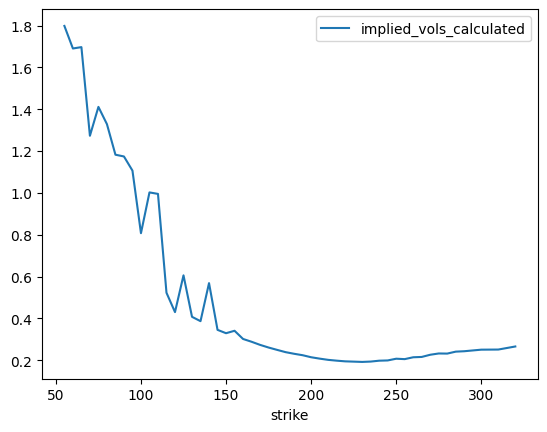

In [23]:
df_calls = appl_vol_surface_from_calls.DataWithImpliedVolsCalculated()
df_calls[df_calls.Expiration_Date == datetime.date(2024, 6, 21)].plot(x = 'strike', y=['implied_vols_calculated'])

Pour pallier cette limite, nous avons eu besoin d'un modèle de diffusion permettant de capturer le smile de volatilité. Nous avons choisi le modèle d'Heston :
$$
dS_t = \mu S_t dt + \sqrt{v_t} S_t dW_{t,S}
$$
$$
dv_t = \kappa (\theta - v_t) dt + \xi \sqrt{v_t} dW_{t,v}
$$

Ce modèle contient 5 paramètres à calibrer : \(\kappa\), \(\theta\), \(\xi\), \(\rho\) (la corrélation entre les deux browniens), et \(v_0\) (la volatilité initiale).

Pour la calibration, on utilise la formule semi-fermée et on minimise l'erreur entre le prix donné par le modèle d'Heston et le prix du marché (soit les Calls soit les Puts). La formule semi-fermée du prix du call est donnée par :
$$
C = \frac{1}{2}(S_t - Ke^{-r(T-t)}) + \frac{1}{\pi} \int_0^\infty \text{Re} \left[ \frac{e^{-i\varphi\ln(K)}f(s - i)}{is} - \frac{Kf(s)}{is} \right] ds
$$

Pour le put, nous le déduisons à partir de la parité call-put.

In [21]:
pricer_heston = VanillaPricerWithHestonCalibrated(market_date, 'AAPL', 'Calls', r, d)

D'après la figure ci-dessous, nous remarquons que le smile d'Heston est proche du smile du marché

<Axes: title={'center': 'Interpolated_Vol_from_Calls'}, xlabel='K'>

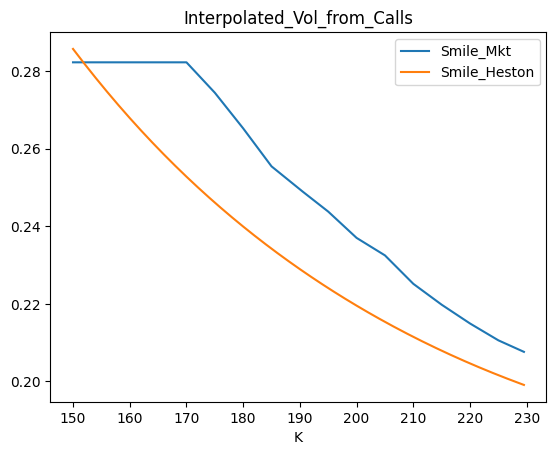

In [30]:
list_dicts_sigmas = []
T=1
for k_i in range(160):
    K = 150 + k_i*0.5
    dic_k = {}
    dic_k['K'] = K
    dic_k['Smile_Mkt'] =  appl_vol_surface_from_calls.InterpolatedVol(K,T)
    dic_k['Smile_Heston'] = pricer_heston.ImpliedVol(K,T)
    list_dicts_sigmas +=[dic_k]
    
df_vols = pd.DataFrame(list_dicts_sigmas)
df_vols.plot(x='K', y = ['Smile_Mkt', 'Smile_Heston'], title = 'Interpolated_Vol_from_Calls')

Nous utilisons également une approche de Monte Carlo pour le pricing des options exotiques. Pour la simulation des trajectoires du prix et de la volatilité de Heston, nous utilisons le schéma suivant :

$$
S_{t+i} = S_t e^{ \left( r - \frac{v_t}{2} \right) \Delta t + \sqrt{v_t \Delta t} \cdot dW^S_t }
$$
$$
v_{t+1} = v_t + \kappa ( \theta - v_t ) \Delta t + \xi \sqrt{v_t \Delta t} \cdot dW^v_t
$$

Pour plus de détails, consultez la classe `MonteCarloSimulatorWithHeston` du module `MonteCarloSimulator.py`.